In [1]:
import h5py
from openff.toolkit import Molecule, Quantity, unit
from openff.qcsubmit.factories import OptimizationDatasetFactory
from openff.qcsubmit.datasets import OptimizationDataset
import numpy as np
from openff.qcsubmit.common_structures import QCSpec, SCFProperties

# Generating molecules

Pulling out the lowest energy conformer of each molecule to run a full geometry optimization on.

SPICE2 hdf5 file can be downloaded [here](https://zenodo.org/records/10975225).
Not including with submission as it is 35 GB. Including the code here for provenence.

In [2]:
# # Extract the Dipeptides subset

# dipeptide_results = {}
# with h5py.File("/Users/amcisaac/Documents/SPICE/SPICE-2.0.1.hdf5") as f:
#     for key in list(f.keys()):
#         group = f[key]
#         subset = group['subset'][()][0].decode('utf-8')

#         if subset == 'SPICE Dipeptides Single Points Dataset v1.3':
#             smiles = group['smiles'][()][0].decode('utf-8')
#             confs = group['conformations'][()]
#             energies = group['dft_total_energy'][()]
#             dEs = energies - min(energies)
#             dipeptide_results[smiles] = {'conformations':confs,'dft_total_energy':energies,'dEs':dEs}

In [3]:
# # Identify the lowest energy conformer for each molecule

# mols=[]
# for i,key in enumerate(list(dipeptide_results.keys())):
#     result = dipeptide_results[key]
#     idx_lowe = np.argmin(result['dEs'])
#     conf_lowe = result['conformations'][idx_lowe]

#     mol = Molecule.from_mapped_smiles(key,allow_undefined_stereo=True)
#     mol.add_conformer(Quantity(conf_lowe, unit.bohr)) # OpenFF converts to angstroms upon addition, then back to Bohr when adding to dataset

#     mols.append(mol)
    

In [4]:
# # Save as a dataset just to minimize converting between different ecosystems.
# # Could also save as SDF files
# dataset_factory_molsonly = OptimizationDatasetFactory()

# dataset_molsonly = dataset_factory_molsonly.create_dataset(
#     dataset_name="SPICE Dipeptide Molecules Placeholder",
#     tagline="SPICE Dipeptide Molecules Placeholder.",
#     description=(
#         "SPICE Dipeptide Molecules Placeholder"
#     ),
#     molecules=mols
# )

# dataset_molsonly.export_dataset("dipeptide_minEconf.json")

# Generate the actual dataset

In [2]:
dipeptide_lowestE_confs = list(OptimizationDataset.parse_file('dipeptide_minEconf.json').molecules)

In [5]:
dataset_factory = OptimizationDatasetFactory(
    qc_specifications={
        "default-mbis": QCSpec(
            program="psi4",
            method="b3lyp-d3bj",
            basis="DZVP",
            spec_name="default-mbis",
            spec_description=(
                "OpenFF default level of theory with MBIS charges"
            ),
            scf_properties=[
                        SCFProperties.Dipole,
                        SCFProperties.Quadrupole,
                        SCFProperties.MBISCharges,
                        SCFProperties.MayerIndices,
                        SCFProperties.WibergLowdinIndices,
                    ]
        ),
            
    }
)

dataset = dataset_factory.create_dataset(
    dataset_name="SPICE Dipeptides Lowest E Conformer Optimization Dataset v4.0",
    tagline="B3LYP-D3BJ/DZVP relaxation of the lowest energy conformer of each molecule in the dipeptides dataset.",
    description=(
        "A dataset containing the lowest energy conformer of all molecules from the "
        "`Dipeptides` subset of the SPICE dataset, "
        "optimized at the OpenFF default level of theory (B3LYP-D3BJ/DZVP). " 
        "Detailed description on how the original dataset is generated can be found at https://github.com/openmm/spice-dataset/tree/main/dipeptides."
    ),
    molecules=dipeptide_lowestE_confs,
    
)
dataset.metadata.submitter = "amcisaac"
dataset.metadata.long_description_url = ("https://github.com/openforcefield/qca-dataset-submission/tree/master/submissions/2025-01-08-SPICE-Dipeptides-Lowest-E-Conformer-Optimization-Dataset-v4.0") 

Deduplication                 : 100%|████████| 677/677 [00:00<00:00, 868.18it/s]
[16:38:24] WARNING: Proton(s) added/removed             | 0/677 [00:00<?, ?it/s]

[16:38:24] WARNING: Proton(s) added/removed

[16:38:24] WARNING: Proton(s) added/removed

[16:38:24] WARNING: Proton(s) added/removed

[16:38:24] WARNING: Proton(s) added/removed

[16:38:24] WARNING: Proton(s) added/removed

[16:38:24] WARNING: Proton(s) added/removed

[16:38:24] WARNING: Proton(s) added/removed

[16:38:24] WARNING: Proton(s) added/removed

[16:38:24] WARNING: Proton(s) added/removed

[16:38:24] WARNING: Proton(s) added/removed   | 14/677 [00:00<00:04, 136.68it/s]

[16:38:24] WARNING: Proton(s) added/removed

[16:38:25] WARNING: Proton(s) added/removed

[16:38:25] WARNING: Proton(s) added/removed

[16:38:25] WARNING: Proton(s) added/removed

[16:38:25] WARNING: Proton(s) added/removed

[16:38:25] WARNING: Proton(s) added/removed   | 28/677 [00:00<00:05, 126.06it/s]

[16:38:25] WARNING: Proton(s) added/removed

In [6]:
dataset.qc_specifications

{'default-mbis': QCSpec(method='b3lyp-d3bj', basis='DZVP', program='psi4', spec_name='default-mbis', spec_description='OpenFF default level of theory with MBIS charges', store_wavefunction=<WavefunctionProtocolEnum.none: 'none'>, implicit_solvent=None, maxiter=200, scf_properties=[<SCFProperties.Dipole: 'dipole'>, <SCFProperties.Quadrupole: 'quadrupole'>, <SCFProperties.MBISCharges: 'mbis_charges'>, <SCFProperties.MayerIndices: 'mayer_indices'>, <SCFProperties.WibergLowdinIndices: 'wiberg_lowdin_indices'>], keywords={})}

## Analyze dataset

In [7]:
n_confs = np.array(
    [mol.n_conformers for mol in dataset.molecules]
)

n_heavy_atoms = np.array(
    [mol.to_rdkit().GetNumHeavyAtoms() for mol in dataset.molecules]
)

masses = np.array([
    sum([atom.mass.m for atom in mol.atoms])
    for mol in dataset.molecules
])

elements = set(
    atom.symbol
    for mol in dataset.molecules
    for atom in mol.atoms
)

unique_charges = [str(charge) for charge in sorted(set([
    mol.total_charge.m_as(unit.elementary_charge)
    for mol in dataset.molecules
]))]

from collections import Counter

print("# heavy atoms")
counts = Counter(n_heavy_atoms)
for n_heavy in sorted(counts):
    print(f"{str(n_heavy):>3}: {counts[n_heavy]}")


# heavy atoms
 13: 1
 14: 2
 15: 7
 16: 12
 17: 27
 18: 40
 19: 61
 20: 76
 21: 90
 22: 93
 23: 81
 24: 62
 25: 47
 26: 28
 27: 22
 28: 14
 29: 7
 30: 4
 31: 2
 33: 1


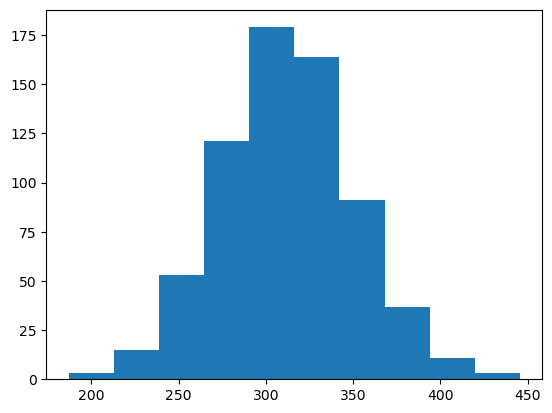

In [8]:
from matplotlib import pyplot as plt
plt.figure()
plt.hist(masses)
plt.show()

Only a few molecules are over 400 Da, hopefully this is okay?

In [9]:
print('* Name: {}'.format(dataset.dataset_name))
print('* Number of unique molecules: {}'.format(dataset.n_molecules))
print('* Number of conformers: {}'.format(dataset.n_records))
print('* Number of conformers (min, mean, max): {:.2f}, {:.2f}, {:.2f}'.format(min(n_confs),np.mean(n_confs),max(n_confs)))
print('* Molecular weight (min, mean, max): {:.2f}, {:.2f}, {:.2f}'.format(min(masses),np.mean(masses),max(masses)))
print('* Charges: {}'.format(' '.join(unique_charges)))

print("## Metadata")
print(f"* Elements: {{{', '.join(dataset.metadata.dict()['elements'])}}}")

def print_field(od, field): print(f"  * {field}: {od[field]}")

fields = ["basis", "implicit_solvent", "keywords", "maxiter", "method", "program"]
for spec, obj in dataset.qc_specifications.items():
    od = obj.dict()
    print("* Spec:", spec)
    for field in fields:
        print_field(od, field)
    print("  * SCF properties:")
    for field in od["scf_properties"]:
        print(f"    * {field}")

* Name: SPICE Dipeptides Lowest E Conformer Optimization Dataset v4.0
* Number of unique molecules: 677
* Number of conformers: 677
* Number of conformers (min, mean, max): 1.00, 1.00, 1.00
* Molecular weight (min, mean, max): 187.20, 313.73, 445.52
* Charges: -2.0 -1.0 0.0 1.0 2.0
## Metadata
* Elements: {S, N, O, C, H}
* Spec: default-mbis
  * basis: DZVP
  * implicit_solvent: None
  * keywords: {}
  * maxiter: 200
  * method: b3lyp-d3bj
  * program: psi4
  * SCF properties:
    * dipole
    * quadrupole
    * mbis_charges
    * mayer_indices
    * wiberg_lowdin_indices


## Update description based on analysis and export

In principle, we could analyze the molecules before adding them to the dataset, and just do the description once. I'm doing it after in order to make sure it's reflective of any changes made when adding molecules to the dataset.

In [10]:
dataset.metadata.long_description=(( "A dataset containing the lowest energy conformer of all molecules from the "
        "`Dipeptides` subset of the SPICE dataset, "
        "optimized at the OpenFF default level of theory (B3LYP-D3BJ/DZVP). " 
        "Detailed description on how the original dataset is generated can be found at https://github.com/openmm/spice-dataset/tree/main/dipeptides.\n\n"
        "Dataset information:\n"
        "* Number of unique molecules: {}\n"
        "* Number of conformers: {}\n"
        "* Number of conformers (min, mean, max): {:.2f}, {:.2f}, {:.2f}\n"
        "* Molecular weight (min, mean, max): {:.2f}, {:.2f}, {:.2f}\n"
        "* Charges: {}\n"
        "* Elements: {}\n"
        "* Submission directory: {}".format(dataset.n_molecules,dataset.n_records,min(n_confs),np.mean(n_confs),max(n_confs),min(masses),np.mean(masses),max(masses),' '.join(unique_charges),f"{{{', '.join(dataset.metadata.dict()['elements'])}}}",dataset.metadata.long_description_url)
        ))

dataset.description = dataset.metadata.long_description

In [11]:
print(dataset.description)

A dataset containing the lowest energy conformer of all molecules from the `Dipeptides` subset of the SPICE dataset, optimized at the OpenFF default level of theory (B3LYP-D3BJ/DZVP). Detailed description on how the original dataset is generated can be found at https://github.com/openmm/spice-dataset/tree/main/dipeptides.

Dataset information:
* Number of unique molecules: 677
* Number of conformers: 677
* Number of conformers (min, mean, max): 1.00, 1.00, 1.00
* Molecular weight (min, mean, max): 187.20, 313.73, 445.52
* Charges: -2.0 -1.0 0.0 1.0 2.0
* Elements: {S, N, O, C, H}
* Submission directory: https://github.com/openforcefield/qca-dataset-submission/tree/master/submissions/2025-01-08-SPICE-Dipeptides-Lowest-E-Conformer-Optimization-Dataset-v4.0


In [12]:
print(dataset.metadata.long_description)

A dataset containing the lowest energy conformer of all molecules from the `Dipeptides` subset of the SPICE dataset, optimized at the OpenFF default level of theory (B3LYP-D3BJ/DZVP). Detailed description on how the original dataset is generated can be found at https://github.com/openmm/spice-dataset/tree/main/dipeptides.

Dataset information:
* Number of unique molecules: 677
* Number of conformers: 677
* Number of conformers (min, mean, max): 1.00, 1.00, 1.00
* Molecular weight (min, mean, max): 187.20, 313.73, 445.52
* Charges: -2.0 -1.0 0.0 1.0 2.0
* Elements: {S, N, O, C, H}
* Submission directory: https://github.com/openforcefield/qca-dataset-submission/tree/master/submissions/2025-01-08-SPICE-Dipeptides-Lowest-E-Conformer-Optimization-Dataset-v4.0


In [13]:
dataset.export_dataset("dataset.json.bz2")
dataset.molecules_to_file('dataset.smi', 'smi')
dataset.visualize("dataset.pdf", columns=8)